# Data Importing
Load the time-series raw data using pandas and inspect the first 5 rows

In [2]:
import pandas as pd
ts = pd.read_csv('Data\exchange-2_cpc_results.csv')
ts.head()

,timestamp,value
0,2011-07-01 00:00:01,0.081965
1,2011-07-01 01:00:01,0.098972
2,2011-07-01 02:00:01,0.065314
3,2011-07-01 03:00:01,0.070663
4,2011-07-01 04:00:01,0.102490


# Time-Series Conversion
Using pandas Series, convert the dataset to a timeseries by:
* Assigning timestamps as index
* Defining discrete timesteps (time-series frequency/sampling)

In [16]:
ts['timestamp'] = pd.to_datetime(ts['timestamp'])
ts.set_index('timestamp', drop=True, inplace=True)
ts = ts.resample('h').mean()
ts.columns = ['cpc']
ts = ts['cpc']
ts.head()

timestamp
2011-07-01 00:00:00    0.081965
2011-07-01 01:00:00    0.098972
2011-07-01 02:00:00    0.065314
2011-07-01 03:00:00    0.070663
2011-07-01 04:00:00    0.102490
Freq: H, Name: cpc, dtype: float64

# Missing Value Handling
Check if any data is missing and impute them

In [17]:
ts.isna().sum()

25

25 observations (i.e. hours of data) are missing. Print out their location in the TS to identify whether missing values or scattered

In [18]:
ts.index[ts.isna()]

DatetimeIndex(['2011-07-21 05:00:00', '2011-08-08 18:00:00',
               '2011-08-10 16:00:00', '2011-08-15 22:00:00',
               '2011-08-15 23:00:00', '2011-09-01 19:00:00',
               '2011-09-01 20:00:00', '2011-09-01 21:00:00',
               '2011-09-01 22:00:00', '2011-09-01 23:00:00',
               '2011-09-02 00:00:00', '2011-09-02 01:00:00',
               '2011-09-02 02:00:00', '2011-09-02 03:00:00',
               '2011-09-02 04:00:00', '2011-09-02 05:00:00',
               '2011-09-02 06:00:00', '2011-09-02 07:00:00',
               '2011-09-02 08:00:00', '2011-09-02 09:00:00',
               '2011-09-02 10:00:00', '2011-09-02 11:00:00',
               '2011-09-02 12:00:00', '2011-09-02 13:00:00',
               '2011-09-02 14:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

A large 'block' of values is missing (on 9/2/2011). Simple filling of this block is not possible without altering the properties of the timeseries. A better technique would be to use time-series forecast modeling to fill this block.
In order to do so, trim the series at the 9/2/2011 cut off. For the remaining missing values, a simple 'padding' can be used

In [22]:
ts_clean = ts.loc[ts.index < '2011-09-02']
ts_clean.fillna(method='pad', inplace=True)

# Train-Validate-Test Splitting
A common practice is to do a 70-30 or 85-15 series split for training and evaluating models. However, even when models are optimized and selected based on the evaluation set, there is no guarantee that the evaluation & training set together were fully representative of future unobserved data. Therefore, a better practice is to perform 2 splits (e.g. 75-15-15), where the 3rd parition is neither used for training nor for validation (e.g. when doing cross-validation or hyperparameter selection). Therefore we can assess the perofrmance of the selected models with higher confidence. 

In [26]:
n_obs = ts_clean.shape[0]
split1 = ts_clean.index[int(0.7*n_obs)]
split2 = ts_clean.index[int(0.85*n_obs)]
train_ts = ts_clean.loc[ts_clean.index <= split1]
val_ts = ts_clean.loc[(ts_clean.index > split1) & (ts_clean.index <= split2)]
test_ts = ts_clean.loc[ts_clean.index > split2]

# Visualize
matplotlib provides good tools for plotting and inspecting timeseries data visually. This can be done through multiple lines of code to create plot for each partition, define axes, setting labels, etc.
Alternatively, a shortcut is to use the pandas plot method which runs matplotlib backend and does this for us in one or 2 lines of code

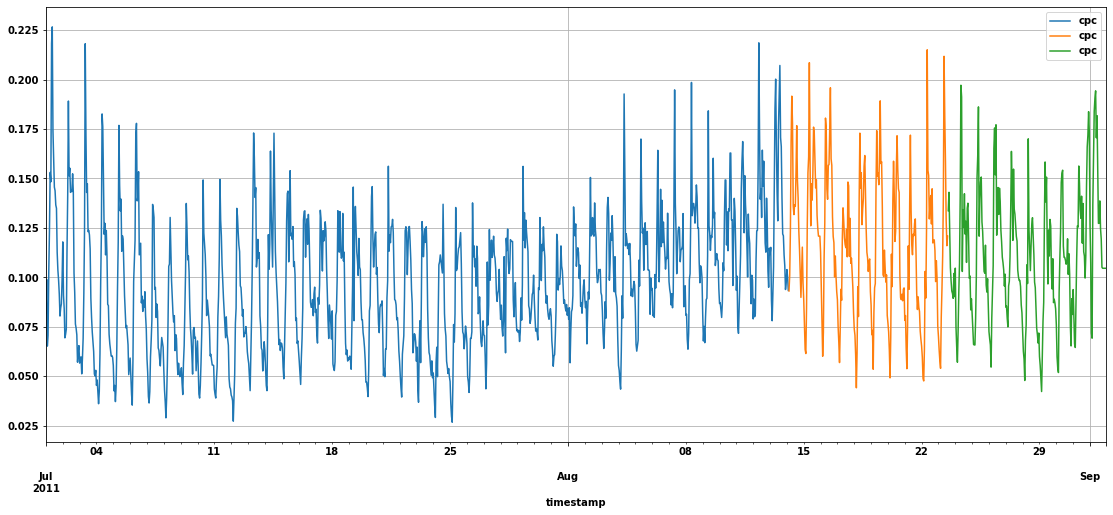

In [30]:
pd.concat([train_ts, val_ts, test_ts], axis=1).plot(grid=True, figsize=(19,8))

# Data Exporting
To re-use the cleaned and partitioned data, rather than exporting again to a text format (e.g. csv), it's best to pickle it using python libraries. This way when the the data are imported and unplickled again back into pandas dataframe.

In [31]:
from joblib import dump
file = {'train': train_ts,
        'val': val_ts,
       'test': test_ts}
dump(file, 'data_clean.z', compress=True)

['data_clean.z']